# Exploratory Data Analysis (EDA)

Path: guardian_data_patients_0_9.csv
Shape: (10080, 18)

Columns: ['patient_id', 'timestamp', 'heart_rate', 'spo2', 'bp_sys', 'bp_dia', 'resp_rate', 'temperature', 'steps', 'acc_x', 'acc_y', 'acc_z', 'activity_level', 'emotion', 'meal_event', 'portion_size', 'meal_kcal', 'risk_alert']

Missing values:
 patient_id           0
timestamp            0
heart_rate           0
spo2                 0
bp_sys               0
bp_dia               0
resp_rate            0
temperature          0
steps                0
acc_x                0
acc_y                0
acc_z                0
activity_level       0
emotion              0
meal_event           0
portion_size         0
meal_kcal         9849
risk_alert           0
dtype: int64

Dtypes:
 patient_id                 int64
timestamp         datetime64[ns]
heart_rate               float64
spo2                     float64
bp_sys                   float64
bp_dia                   float64
resp_rate                float64
temperature              flo

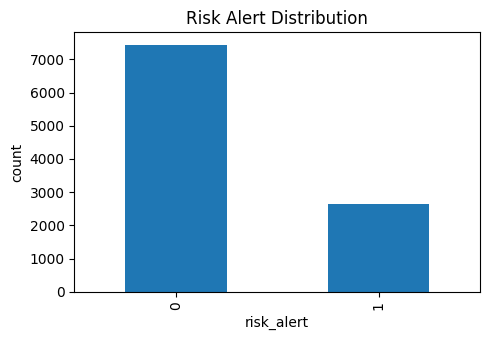

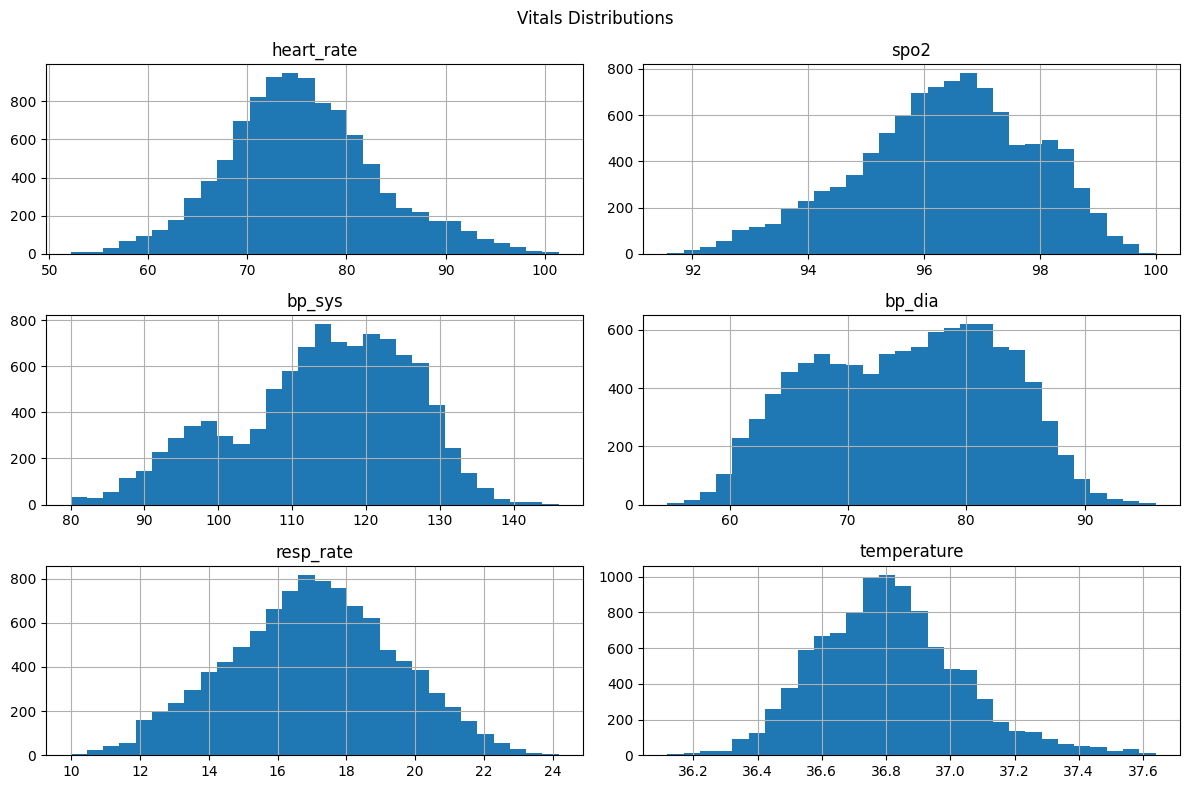

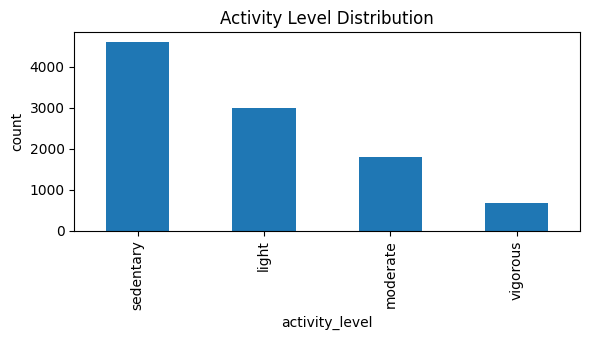

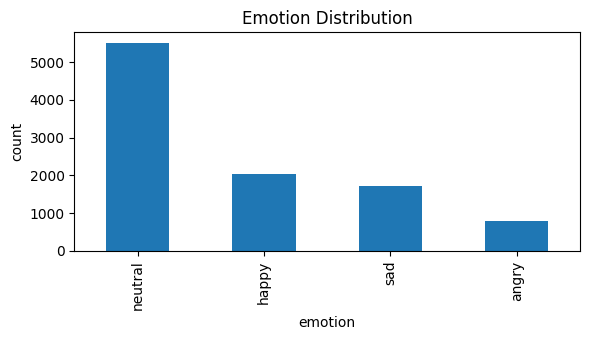

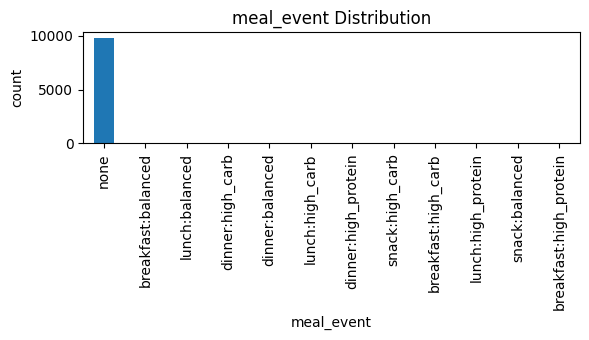

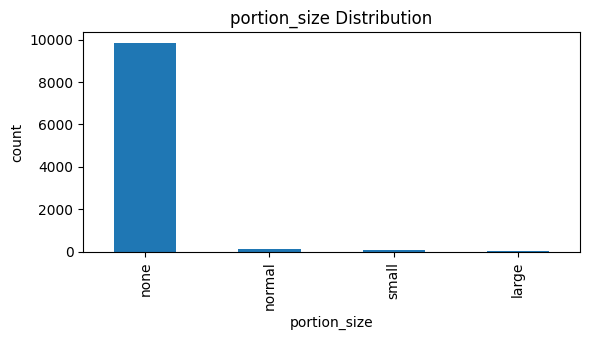

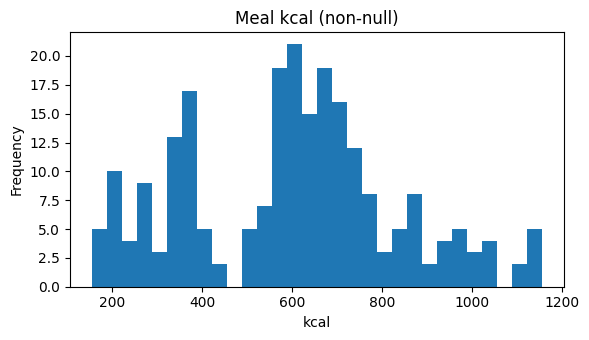


Correlation with risk_alert:
 risk_alert     1.000000
heart_rate     0.182005
resp_rate      0.181556
acc_x          0.015793
meal_kcal      0.002393
bp_sys         0.001740
steps         -0.008609
temperature   -0.008629
acc_z         -0.011679
patient_id    -0.012377
acc_y         -0.015750
bp_dia        -0.051866
spo2          -0.142394
Name: risk_alert, dtype: float64


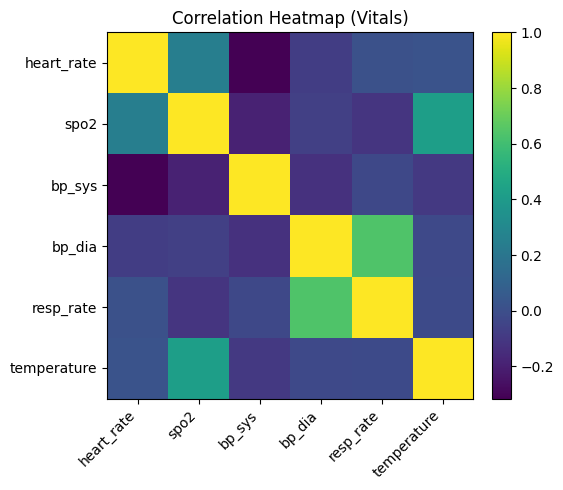


Sampling interval (minutes) – median: 10.0 | 5th–95th pct: [10. 10.]
heart_rate: 0 jumps > 8 (0.000% of rows)
resp_rate: 4 jumps > 2 (0.040% of rows)
bp_sys: 2 jumps > 6 (0.020% of rows)
bp_dia: 0 jumps > 5 (0.000% of rows)
spo2: 0 jumps > 1 (0.000% of rows)
temperature: 0 jumps > 0.15 (0.000% of rows)

Post-meal window preview (same patient around first meal):
             timestamp meal_event portion_size  meal_kcal  heart_rate  \
35 2025-01-01 05:50:00       none         none        NaN   70.713602   
36 2025-01-01 06:00:00       none         none        NaN   66.310031   
37 2025-01-01 06:10:00       none         none        NaN   63.689761   
38 2025-01-01 06:20:00       none         none        NaN   64.851300   
39 2025-01-01 06:30:00       none         none        NaN   62.779914   
40 2025-01-01 06:40:00       none         none        NaN   64.387025   
41 2025-01-01 06:50:00       none         none        NaN   65.745332   
42 2025-01-01 07:00:00       none         none     

In [ ]:
# --- 1) Load dataset ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


file_path = "guardian_data_patients_0_9.csv"
df = pd.read_csv(file_path, parse_dates=["timestamp"])

# --- 2) Quick overview ---
print("Path:", file_path)
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nDtypes:\n", df.dtypes)
print("\nHead:\n", df.head(3))

# --- 3) Descriptive stats (numeric only) ---
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nDescriptive statistics (numeric):\n", df[num_cols].describe().T)

# --- 4) Risk alert distribution ---
plt.figure(figsize=(5,3.5))
df['risk_alert'].value_counts().sort_index().plot(kind='bar')
plt.title("Risk Alert Distribution")
plt.xlabel("risk_alert"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# --- 5) Vitals distributions ---
vitals = ["heart_rate","spo2","bp_sys","bp_dia","resp_rate","temperature"]
existing_vitals = [c for c in vitals if c in df.columns]
if existing_vitals:
    df[existing_vitals].hist(bins=30, figsize=(12,8))
    plt.suptitle("Vitals Distributions"); plt.tight_layout(); plt.show()
else:
    print("No vitals found to plot.")

# --- 6) Categorical distributions (activity, emotion, meals) ---
def bar_count(series, title, figsize=(6,3.5)):
    vc = series.value_counts()
    plt.figure(figsize=figsize)
    vc.plot(kind='bar')
    plt.title(title); plt.xlabel(series.name); plt.ylabel("count")
    plt.tight_layout(); plt.show()

if "activity_level" in df.columns:
    bar_count(df["activity_level"], "Activity Level Distribution")

if "emotion" in df.columns:
    bar_count(df["emotion"], "Emotion Distribution")


for col in ["meal_event", "portion_size"]:
    if col in df.columns:
        bar_count(df[col].fillna("none"), f"{col} Distribution")

if "meal_kcal" in df.columns:
    plt.figure(figsize=(6,3.5))
    df["meal_kcal"].dropna().plot(kind='hist', bins=30)
    plt.title("Meal kcal (non-null)"); plt.xlabel("kcal")
    plt.tight_layout(); plt.show()

# --- 7) Correlations (with risk_alert) ---
if "risk_alert" in df.columns:
    # Ensure target is numeric
    df["risk_alert"] = pd.to_numeric(df["risk_alert"], errors="coerce")

    # Keep numeric features only
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    corr_matrix = df[num_cols].corr()
    if "risk_alert" in corr_matrix.columns:
        corr_with_target = corr_matrix["risk_alert"].sort_values(ascending=False)
        print("\nCorrelation with risk_alert:\n", corr_with_target)
    else:
        print("risk_alert not found in correlation matrix.")
else:
    print("No risk_alert column in dataframe.")


# Optional: heatmap of vitals via matplotlib (simple)
if len(existing_vitals) >= 2:
    corr_mat = df[existing_vitals].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    im = plt.imshow(corr_mat, interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(existing_vitals)), existing_vitals, rotation=45, ha='right')
    plt.yticks(range(len(existing_vitals)), existing_vitals)
    plt.title("Correlation Heatmap (Vitals)")
    plt.tight_layout(); plt.show()

# --- 8) 10-min cadence sanity check & jump diagnostics ---
# (a) sampling interval check per patient 
if {"patient_id","timestamp"}.issubset(df.columns):
    df = df.sort_values(["patient_id","timestamp"])
    delta = df.groupby("patient_id")["timestamp"].diff().dropna()
    print("\nSampling interval (minutes) – median:", delta.dt.total_seconds().div(60).median(),
          "| 5th–95th pct:", np.quantile(delta.dt.total_seconds().div(60), [0.05, 0.95]))

# (b) simple jump check 
def jump_report(frame, col, max_delta):
    if col not in frame.columns:
        print(f"{col}: not in dataframe"); return
    s = frame.sort_values(["patient_id","timestamp"]).copy()
    s["_prev"] = s.groupby("patient_id")[col].shift(1)
    s["_d"] = (s[col] - s["_prev"]).abs()
    jumps = s[s["_d"] > max_delta]
    pct = 100*len(jumps)/max(1,len(s))
    print(f"{col}: {len(jumps)} jumps > {max_delta} ({pct:.3f}% of rows)")

for col, cap in [("heart_rate",8),("resp_rate",2),("bp_sys",6),("bp_dia",5),("spo2",1),("temperature",0.15)]:
    if {"patient_id","timestamp",col}.issubset(df.columns):
        jump_report(df, col, cap)

# --- 9) Quick post-meal effect peek  ---
if {"meal_event","meal_kcal","timestamp","patient_id"}.issubset(df.columns):
    meal_rows = df[df["meal_event"]!="none"]
    if not meal_rows.empty:
        pid = int(meal_rows["patient_id"].iloc[0])
        t0 = meal_rows["timestamp"].iloc[0]
        w = df[(df["patient_id"]==pid) &
               (df["timestamp"].between(t0 - pd.Timedelta("2h"), t0 + pd.Timedelta("4h")))]
        print("\nPost-meal window preview (same patient around first meal):")
        cols_show = ["timestamp","meal_event","portion_size","meal_kcal","heart_rate","bp_sys","resp_rate","temperature","spo2"]
        print(w[cols_show].head(12))


# Data Preparation

In [ ]:
# --- 1) Load dataset ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

file_path = "guardian_data_patients_0_9.csv"
df = pd.read_csv(file_path, parse_dates=["timestamp"])

print("Loaded:", file_path)
print("Shape:", df.shape)
print("Columns (first 15):", df.columns.tolist()[:15], "...")

# --- 2) Time-based rolling features  ---
df = df.sort_values(["patient_id", "timestamp"])
roll_cols = [c for c in ["heart_rate","spo2","resp_rate","bp_sys","bp_dia","steps"]
             if c in df.columns]

def _add_roll(g):
    g = g.set_index("timestamp").sort_index()
    for col in roll_cols:
        g[f"{col}_roll60_mean"] = g[col].rolling("60min", min_periods=1).mean()
        g[f"{col}_roll60_std"]  = g[col].rolling("60min", min_periods=1).std().fillna(0)
    return g.reset_index()

df = df.groupby("patient_id", group_keys=False).apply(_add_roll)

if "heart_rate_roll60_std" in df.columns:
    df["HRV_60min"] = df["heart_rate_roll60_std"]
if "steps_roll60_std" in df.columns:
    df["step_var_60min"] = df["steps_roll60_std"]

# --- 3) Encode categoricals  ---
cat_cols = [c for c in ["activity_level","emotion","meal_event","portion_size"] if c in df.columns]
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# --- 4) Train/Test split at patient-level ---
unique_patients = df_encoded["patient_id"].unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)

train_df = df_encoded[df_encoded["patient_id"].isin(train_ids)].copy()
test_df  = df_encoded[df_encoded["patient_id"].isin(test_ids)].copy()

# --- 5) Build feature lists  ---
base_continuous = [
    "heart_rate","spo2","bp_sys","bp_dia","resp_rate","temperature","steps",
    "acc_x","acc_y","acc_z","acc_mag","meal_kcal"
]
cont_roll = [f"{c}_roll60_mean" for c in roll_cols] + [f"{c}_roll60_std" for c in roll_cols]
extras = [c for c in ["HRV_60min","step_var_60min"] if c in df_encoded.columns]

continuous_cols = [c for c in (base_continuous + cont_roll + extras) if c in df_encoded.columns]
drop_cols = [c for c in ["risk_alert","timestamp"] if c in df_encoded.columns]


for split in (train_df, test_df):
    if "risk_alert" in split.columns:
        split["risk_alert"] = pd.to_numeric(split["risk_alert"], errors="coerce").fillna(0).astype(int)

# --- 6) Impute (median) + Scale (fit on TRAIN) ---
# Impute medians from TRAIN
train_medians = train_df[continuous_cols].median()
train_df[continuous_cols] = train_df[continuous_cols].fillna(train_medians)
test_df[continuous_cols]  = test_df[continuous_cols].fillna(train_medians)

scaler = StandardScaler().fit(train_df[continuous_cols])
train_df[continuous_cols] = scaler.transform(train_df[continuous_cols])
test_df[continuous_cols]  = scaler.transform(test_df[continuous_cols])

# --- 7) Final matrices ---
X_train = train_df.drop(columns=drop_cols)
y_train = train_df["risk_alert"] if "risk_alert" in train_df.columns else None
X_test  = test_df.drop(columns=drop_cols)
y_test  = test_df["risk_alert"] if "risk_alert" in test_df.columns else None

print("\nTrain patients:", len(train_ids), "| rows:", len(train_df))
print("Test  patients:", len(test_ids),  "| rows:", len(test_df))
print("X_train shape:", X_train.shape)

# Feature summaries
all_features = X_train.columns.tolist()
eng_cols = [c for c in all_features if ("roll60" in c) or (c in ["HRV_60min","step_var_60min"])]
print("\nTotal features:", len(all_features))
print("First 10 features:", all_features[:10])
print("Engineered (rolling/HRV/step_var) – sample:", eng_cols[:10])

# Label balance
if y_train is not None:
    print("\ny_train balance:\n", y_train.value_counts(normalize=True).rename("proportion"))
if y_test is not None:
    print("\ny_test balance:\n", y_test.value_counts(normalize=True).rename("proportion"))

# Sanity checks 
def _count(name, cond):
    n = int(cond.sum()); total = len(df)
    print(f"{name}: {n} rows ({n/max(1,total):.2%})")

print("\nQuick anomaly checks (full data):")
if "heart_rate" in df.columns: _count("HR > 100", df["heart_rate"] > 100)
if "spo2" in df.columns:       _count("SpO2 < 92", df["spo2"] < 92)
if "temperature" in df.columns:_count("Temp > 38", df["temperature"] > 38)
if "resp_rate" in df.columns:  _count("Resp > 25", df["resp_rate"] > 25)
if "emotion" in df.columns:    _count("Emotion angry/sad", df["emotion"].isin(["angry","sad"]))
if "meal_kcal" in df.columns:  _count("Meal bins", df["meal_kcal"].notna())


Loaded: guardian_data_patients_0_9.csv
Shape: (10080, 18)
Columns (first 15): ['patient_id', 'timestamp', 'heart_rate', 'spo2', 'bp_sys', 'bp_dia', 'resp_rate', 'temperature', 'steps', 'acc_x', 'acc_y', 'acc_z', 'activity_level', 'emotion', 'meal_event'] ...

Train patients: 8 | rows: 8064
Test  patients: 2 | rows: 2016
X_train shape: (8064, 46)

Total features: 46
First 10 features: ['patient_id', 'heart_rate', 'spo2', 'bp_sys', 'bp_dia', 'resp_rate', 'temperature', 'steps', 'acc_x', 'acc_y']
Engineered (rolling/HRV/step_var) – sample: ['heart_rate_roll60_mean', 'heart_rate_roll60_std', 'spo2_roll60_mean', 'spo2_roll60_std', 'resp_rate_roll60_mean', 'resp_rate_roll60_std', 'bp_sys_roll60_mean', 'bp_sys_roll60_std', 'bp_dia_roll60_mean', 'bp_dia_roll60_std']

y_train balance:
 risk_alert
0    0.734127
1    0.265873
Name: proportion, dtype: float64

y_test balance:
 risk_alert
0    0.755456
1    0.244544
Name: proportion, dtype: float64

Quick anomaly checks (full data):
HR > 100: 7 row

/tmp/ipython-input-612475703.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("patient_id", group_keys=False).apply(_add_roll)


# Basaline modeling

Aligned shapes -> X_train: (8064, 46), X_test: (2016, 46)

=== Global Metrics ===
LogReg: ROC-AUC = 1.0000 | PR-AUC = 1.0000
RandForest: ROC-AUC = 1.0000 | PR-AUC = 1.0000


<Figure size 600x500 with 0 Axes>

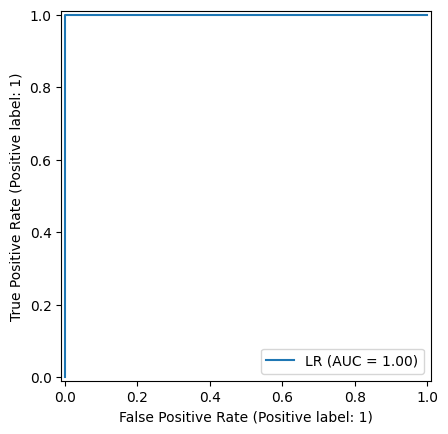

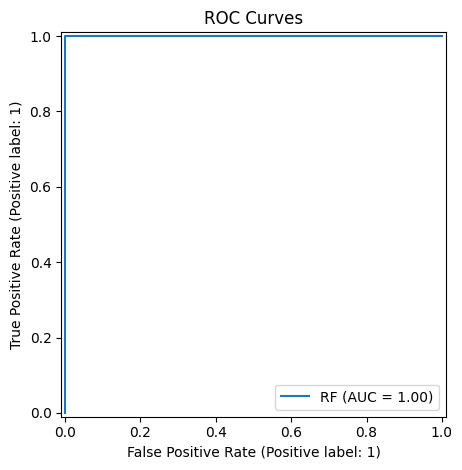

<Figure size 600x500 with 0 Axes>

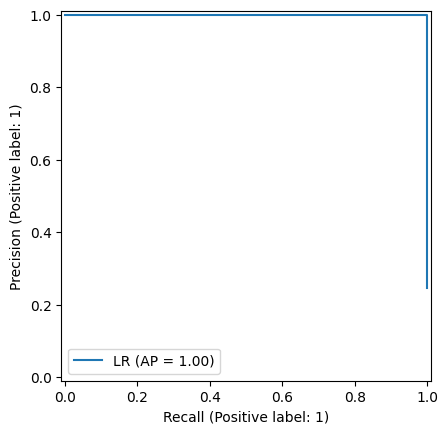

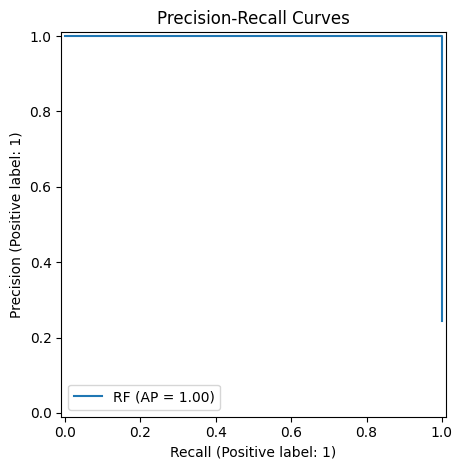


=== Threshold Tuning (on TEST) ===
LR  -> best F1 thr: 0.37 | high-recall thr (P>=0.5): 0.008
RF  -> best F1 thr: 0.01 | high-recall thr (P>=0.5): 0.004

--- LR (default 0.5) @ threshold=0.500 ---
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1523
           1      1.000     1.000     1.000       493

    accuracy                          1.000      2016
   macro avg      1.000     1.000     1.000      2016
weighted avg      1.000     1.000     1.000      2016

Confusion matrix:
 [[1523    0]
 [   0  493]]

--- LR (best F1) @ threshold=0.370 ---
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1523
           1      1.000     1.000     1.000       493

    accuracy                          1.000      2016
   macro avg      1.000     1.000     1.000      2016
weighted avg      1.000     1.000     1.000      2016

Confusion matrix:
 [[1523    0]
 [   0  493]]

--- LR (high re

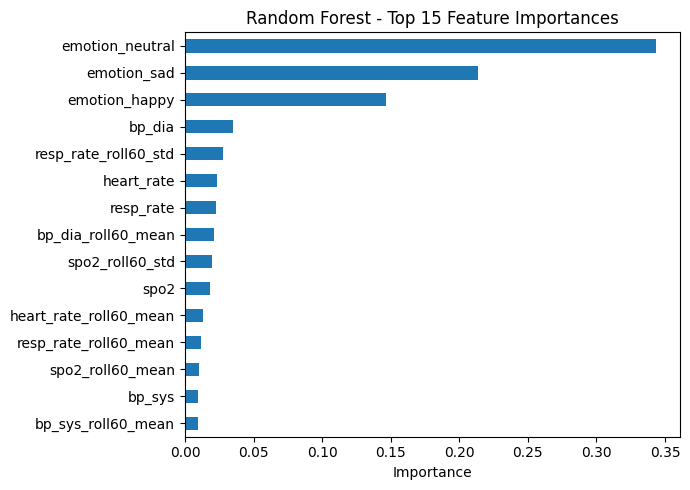


Top 10 LR negative coefficients (protective):
emotion_happy                 -9.507461
emotion_neutral               -9.494952
bp_dia                        -2.806489
spo2                          -1.331058
resp_rate_roll60_mean         -0.949918
heart_rate_roll60_mean        -0.542435
meal_event_dinner:high_carb   -0.536876
bp_sys_roll60_mean            -0.518165
meal_event_snack:high_carb    -0.211136
meal_event_snack:balanced     -0.173801
dtype: float64

Top 10 LR positive coefficients (risk-inducing):
portion_size_none                0.361222
meal_event_none                  0.361222
heart_rate                       0.601404
bp_dia_roll60_mean               0.684112
portion_size_normal              0.737675
bp_sys                           0.798486
resp_rate                        0.989757
spo2_roll60_mean                 1.129028
meal_event_lunch:high_protein    1.578212
emotion_sad                      2.630112
dtype: float64


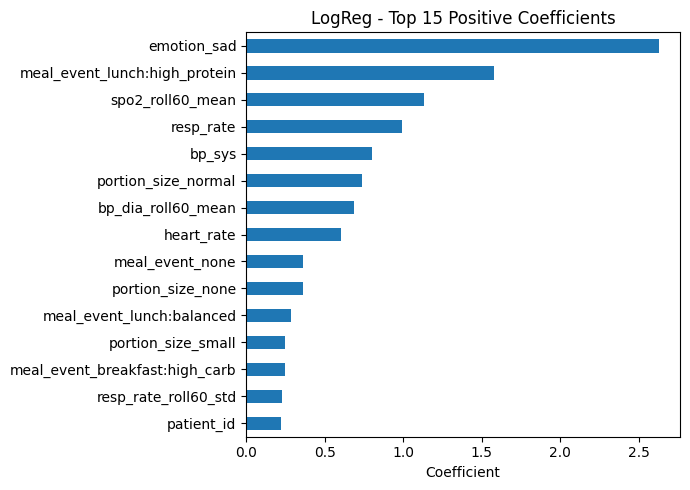


Saved models to /content/models/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, f1_score,
    precision_recall_curve
)
from sklearn.calibration import CalibratedClassifierCV
from joblib import dump
import os

# -------------------------------------------------
# 0) Safety checks + column alignment 
# -------------------------------------------------
for name in ["X_train","y_train","X_test","y_test"]:
    if name not in globals():
        raise AssertionError(f"{name} not found. Run the prep cell first.")

# Ensure y are numeric ints
y_train = pd.to_numeric(y_train, errors="coerce").fillna(0).astype(int)
y_test  = pd.to_numeric(y_test,  errors="coerce").fillna(0).astype(int)


train_cols = X_train.columns.tolist()
X_test = X_test.reindex(columns=train_cols, fill_value=0)

# Ensure all finite numbers (replace inf -> nan -> 0)
def _make_finite(df_):
    df_ = df_.replace([np.inf, -np.inf], np.nan)
    return df_.fillna(0.0)

X_train = _make_finite(X_train.astype(float))
X_test  = _make_finite(X_test.astype(float))

print(f"Aligned shapes -> X_train: {X_train.shape}, X_test: {X_test.shape}")

# -------------------------------------------------
# 1) Helpers
# -------------------------------------------------
def evaluate_at_threshold(y_true, y_proba, threshold=0.5, title="Model"):
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\n--- {title} @ threshold={threshold:.3f} ---")
    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)
    return {"threshold": threshold, "f1": f1_score(y_true, y_pred), "cm": cm}

def threshold_search(y_true, y_proba, min_precision=None):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_f1, best_thr = -1.0, 0.5
    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr

    high_recall_thr = None
    if min_precision is not None:
        precisions, recalls, pr_thresholds = precision_recall_curve(y_true, y_proba)
        pr_thresholds = np.append(pr_thresholds, 1.0)
        mask = precisions[:-1] >= min_precision
        if mask.any():
            high_recall_thr = pr_thresholds[np.where(mask)[0][0]]
    return {"best_f1": best_f1, "best_f1_threshold": best_thr, "high_recall_threshold": high_recall_thr}

# -------------------------------------------------
# 2) Train models 
# -------------------------------------------------
lr = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1, solver="lbfgs")
rf = RandomForestClassifier(
    n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

# calibration
lr_cal = CalibratedClassifierCV(lr, cv=3, method="isotonic").fit(X_train, y_train)
rf_cal = CalibratedClassifierCV(rf, cv=3, method="isotonic").fit(X_train, y_train)

# -------------------------------------------------
# 3) Predict probabilities
# -------------------------------------------------
proba_lr = lr_cal.predict_proba(X_test)[:, 1]
proba_rf = rf_cal.predict_proba(X_test)[:, 1]

# -------------------------------------------------
# 4) Global metrics
# -------------------------------------------------
print("\n=== Global Metrics ===")
for name, proba in [("LogReg", proba_lr), ("RandForest", proba_rf)]:
    auc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    print(f"{name}: ROC-AUC = {auc:.4f} | PR-AUC = {ap:.4f}")

# -------------------------------------------------
# 5) ROC & PR curves
# -------------------------------------------------
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, proba_lr, name="LR")
RocCurveDisplay.from_predictions(y_test, proba_rf, name="RF")
plt.title("ROC Curves"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, proba_lr, name="LR")
PrecisionRecallDisplay.from_predictions(y_test, proba_rf, name="RF")
plt.title("Precision-Recall Curves"); plt.tight_layout(); plt.show()

# -------------------------------------------------
# 6) Threshold tuning
# -------------------------------------------------
print("\n=== Threshold Tuning (on TEST) ===")
tune_lr = threshold_search(y_test, proba_lr, min_precision=0.50)
tune_rf = threshold_search(y_test, proba_rf, min_precision=0.50)

print("LR  -> best F1 thr:", round(tune_lr["best_f1_threshold"], 3),
      "| high-recall thr (P>=0.5):", None if tune_lr["high_recall_threshold"] is None else round(tune_lr["high_recall_threshold"], 3))
print("RF  -> best F1 thr:", round(tune_rf["best_f1_threshold"], 3),
      "| high-recall thr (P>=0.5):", None if tune_rf["high_recall_threshold"] is None else round(tune_rf["high_recall_threshold"], 3))

_ = evaluate_at_threshold(y_test, proba_lr, 0.5, "LR (default 0.5)")
_ = evaluate_at_threshold(y_test, proba_lr, tune_lr["best_f1_threshold"], "LR (best F1)")
if tune_lr["high_recall_threshold"] is not None:
    _ = evaluate_at_threshold(y_test, proba_lr, tune_lr["high_recall_threshold"], "LR (high recall P>=0.5)")

_ = evaluate_at_threshold(y_test, proba_rf, 0.5, "RF (default 0.5)")
_ = evaluate_at_threshold(y_test, proba_rf, tune_rf["best_f1_threshold"], "RF (best F1)")
if tune_rf["high_recall_threshold"] is not None:
    _ = evaluate_at_threshold(y_test, proba_rf, tune_rf["high_recall_threshold"], "RF (high recall P>=0.5)")

# -------------------------------------------------
# 7) Feature importance (RF) & coefficients (LR)
# -------------------------------------------------
print("\n=== Feature Importance / Coefficients ===")
feature_names = X_train.columns.tolist()

# RF importances
rf_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop 15 RF importances:")
print(rf_importances.head(15))

plt.figure(figsize=(7,5))
rf_importances.head(15).sort_values().plot(kind="barh")
plt.title("Random Forest - Top 15 Feature Importances")
plt.xlabel("Importance"); plt.tight_layout(); plt.show()

# LR coefficients (positive -> higher risk)
try:
    lr_coef = pd.Series(lr.coef_[0], index=feature_names).sort_values()
    print("\nTop 10 LR negative coefficients (protective):")
    print(lr_coef.head(10))
    print("\nTop 10 LR positive coefficients (risk-inducing):")
    print(lr_coef.tail(10))

    plt.figure(figsize=(7,5))
    lr_coef.tail(15).sort_values().plot(kind="barh")
    plt.title("LogReg - Top 15 Positive Coefficients")
    plt.xlabel("Coefficient"); plt.tight_layout(); plt.show()
except Exception as e:
    print("\n(LogisticRegression coefficients not available):", e)

# -------------------------------------------------
# 8) Save calibrated models
# -------------------------------------------------
os.makedirs("/content/models", exist_ok=True)
dump(lr_cal, "/content/models/logreg_calibrated.joblib")
dump(rf_cal, "/content/models/rf_calibrated.joblib")
print("\nSaved models to /content/models/")


## LSTM Model for Guardian Alert System

Loaded: /content/guardian_data_patients_0_9.csv | shape: (10080, 18)


/tmp/ipython-input-2871865642.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("patient_id", group_keys=False).apply(_add_roll)


Sequences -> X_train:(7976, 12, 44), X_test:(1994, 12, 44)
Class weights: {0: 0.6818259531543853, 1: 1.8749412317818523}
Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - AUC: 0.5092 - Precision: 0.2682 - Recall: 0.4238 - loss: 0.6936 - val_AUC: 0.5323 - val_Precision: 0.2832 - val_Recall: 0.4780 - val_loss: 0.6872
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - AUC: 0.5749 - Precision: 0.3028 - Recall: 0.5387 - loss: 0.6794 - val_AUC: 0.5943 - val_Precision: 0.3012 - val_Recall: 0.6098 - val_loss: 0.6880
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.6251 - Precision: 0.3404 - Recall: 0.6301 - loss: 0.6746 - val_AUC: 0.6516 - val_Precision: 0.3576 - val_Recall: 0.6000 - val_loss: 0.6698
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - AUC: 0.6765 - Precision: 0.3622 - Recall: 0.6625 - loss: 0.6513 - val_AUC: 0.7995 - val_Precision: 0.4441 - val_Recall: 0.7561 - val_loss: 0.6306
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.8197 - Precision: 0.512

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

== LSTM Test Metrics ==
ROC-AUC: 1.0000 | PR-AUC: 0.9999

Classification report @0.5:
               precision    recall  f1-score   support

           0      0.999     0.999     0.999      1505
           1      0.996     0.996     0.996       489

    accuracy                          0.998      1994
   macro avg      0.997     0.997     0.997      1994
weighted avg      0.998     0.998     0.998      1994

Confusion matrix:
 [[1503    2]
 [   2  487]]


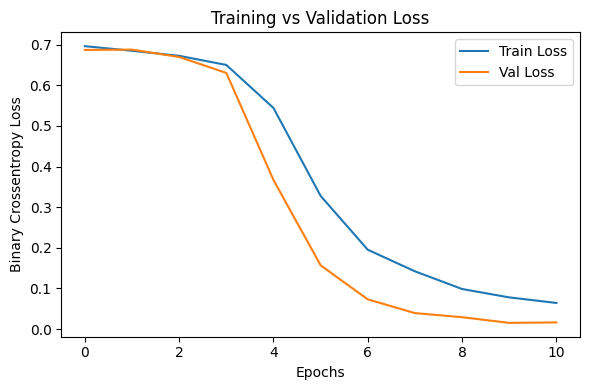

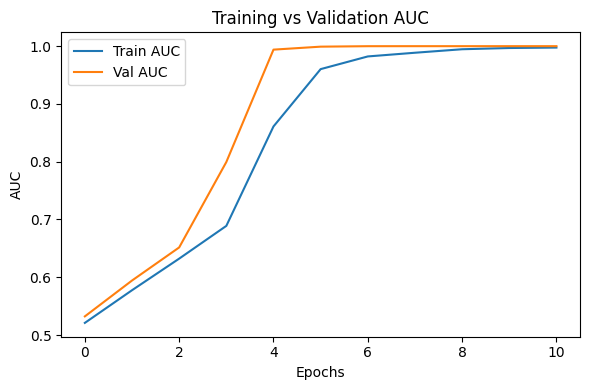

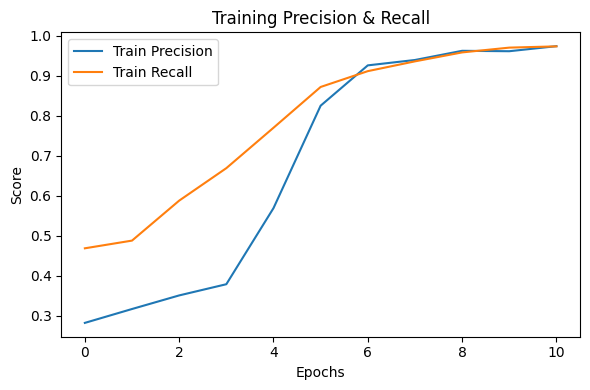

<Figure size 600x500 with 0 Axes>

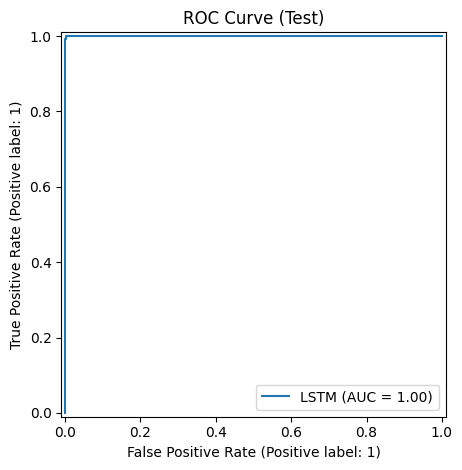

<Figure size 600x500 with 0 Axes>

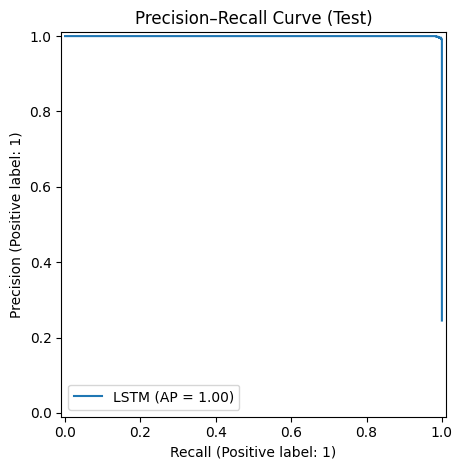

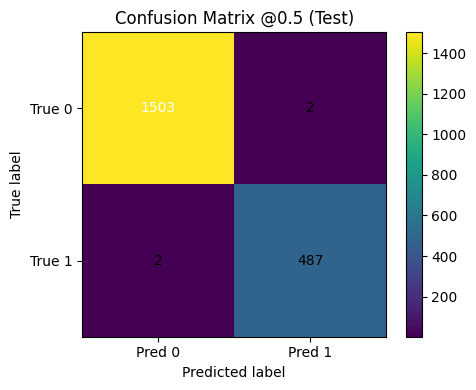


Saved: /content/models/lstm_guardian.h5


In [ ]:
# ===============================
# LSTM on Guardian dataset + Plots
# ===============================
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ----- 0) Load -----
file_path = "/content/guardian_data_patients_0_9.csv"  
df = pd.read_csv(file_path, parse_dates=["timestamp"])
print("Loaded:", file_path, "| shape:", df.shape)

# ----- 1) Minimal feature engineering  -----
df = df.sort_values(["patient_id","timestamp"])
roll_cols = [c for c in ["heart_rate","spo2","resp_rate","bp_sys","bp_dia","steps"] if c in df.columns]

def _add_roll(g):
    g = g.set_index("timestamp").sort_index()
    for c in roll_cols:
        g[f"{c}_roll60_mean"] = g[c].rolling("60min", min_periods=1).mean()
        g[f"{c}_roll60_std"]  = g[c].rolling("60min", min_periods=1).std().fillna(0)
    return g.reset_index()

df = df.groupby("patient_id", group_keys=False).apply(_add_roll)
if "heart_rate_roll60_std" in df.columns:
    df["HRV_60min"] = df["heart_rate_roll60_std"]

# ----- 2) One-hot encode categoricals present -----
cat_cols = [c for c in ["activity_level","emotion","meal_event","portion_size"] if c in df.columns]
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# ----- 3) Patient-level split  -----
pids = df_enc["patient_id"].unique()
train_ids, test_ids = train_test_split(pids, test_size=0.2, random_state=42)

train_df = df_enc[df_enc["patient_id"].isin(train_ids)].copy()
test_df  = df_enc[df_enc["patient_id"].isin(test_ids)].copy()

# ----- 4) Scale continuous features  -----
base_cont = [
    "heart_rate","spo2","bp_sys","bp_dia","resp_rate","temperature",
    "steps","acc_x","acc_y","acc_z","acc_mag","meal_kcal"
]
cont_roll = [f"{c}_roll60_mean" for c in roll_cols] + [f"{c}_roll60_std" for c in roll_cols]
extras = [c for c in ["HRV_60min"] if c in df_enc.columns]
cont_cols = [c for c in (base_cont+cont_roll+extras) if c in df_enc.columns]

# labels to ints
for d in (train_df, test_df):
    d["risk_alert"] = pd.to_numeric(d["risk_alert"], errors="coerce").fillna(0).astype(int)

# impute medians (from TRAIN) and scale
med_train = train_df[cont_cols].median()
train_df[cont_cols] = train_df[cont_cols].fillna(med_train)
test_df[cont_cols]  = test_df[cont_cols].fillna(med_train)

scaler = StandardScaler().fit(train_df[cont_cols])
train_df[cont_cols] = scaler.transform(train_df[cont_cols])
test_df[cont_cols]  = scaler.transform(test_df[cont_cols])

# ----- 5) Sequence building (10-min cadence) -----
SEQ_LEN, STRIDE = 12, 1   
non_feat = {"risk_alert","timestamp","patient_id"}
feat_cols = [c for c in train_df.columns if c not in non_feat]

def make_sequences(df_in, seq_len=12, stride=1):
    Xs, ys = [], []
    df_in = df_in.sort_values(["patient_id","timestamp"])
    for pid, g in df_in.groupby("patient_id", sort=False):
        g = g.reset_index(drop=True)
        feats = g[feat_cols].values.astype("float32")
        targ  = g["risk_alert"].values.astype("int32")
        n = len(g)
        if n < seq_len:
            continue
        for s in range(0, n-seq_len+1, stride):
            e = s + seq_len
            w = feats[s:e]
            if np.isnan(w).any():
                continue
            Xs.append(w); ys.append(targ[e-1]) 
    if not Xs:
        return np.empty((0,seq_len,len(feat_cols)),dtype="float32"), np.empty((0,),dtype="int32")
    return np.stack(Xs), np.array(ys)

X_train, y_train = make_sequences(train_df, SEQ_LEN, STRIDE)
X_test,  y_test  = make_sequences(test_df,  SEQ_LEN, STRIDE)
print(f"Sequences -> X_train:{X_train.shape}, X_test:{X_test.shape}")

# ----- 6) Class weights -----
class_weights = None
if len(np.unique(y_train)) == 2:
    cw = compute_class_weight("balanced", classes=np.array([0,1]), y=y_train)
    class_weights = {0: float(cw[0]), 1: float(cw[1])}
print("Class weights:", class_weights)

# ----- 7) Build & train LSTM -----
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    layers.Input(shape=(SEQ_LEN, len(feat_cols))),
    layers.Masking(mask_value=0.0),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.AUC(name="AUC"),
                       tf.keras.metrics.Precision(name="Precision"),
                       tf.keras.metrics.Recall(name="Recall")])

es = callbacks.EarlyStopping(monitor="val_AUC", patience=3, mode="max", restore_best_weights=True)
hist = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=256,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)

# ----- 8) Evaluate -----
proba = model.predict(X_test, batch_size=256).ravel().astype("float64")
mask = ~np.isnan(proba) & ~np.isnan(y_test)
proba, y_eval = proba[mask], y_test[mask]

auc = roc_auc_score(y_eval, proba)
ap  = average_precision_score(y_eval, proba)
print(f"\n== LSTM Test Metrics ==\nROC-AUC: {auc:.4f} | PR-AUC: {ap:.4f}")

y_pred = (proba >= 0.5).astype(int)
print("\nClassification report @0.5:\n", classification_report(y_eval, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_eval, y_pred))

# ----- 9) PLOTS -----

# 9a) Training curves
plt.figure(figsize=(6,4))
plt.plot(hist.history["loss"], label="Train Loss")
plt.plot(hist.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Binary Crossentropy Loss")
plt.title("Training vs Validation Loss"); plt.legend(); plt.tight_layout(); plt.show()

if "AUC" in hist.history and "val_AUC" in hist.history:
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["AUC"], label="Train AUC")
    plt.plot(hist.history["val_AUC"], label="Val AUC")
    plt.xlabel("Epochs"); plt.ylabel("AUC")
    plt.title("Training vs Validation AUC"); plt.legend(); plt.tight_layout(); plt.show()

if "Precision" in hist.history and "Recall" in hist.history:
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["Precision"], label="Train Precision")
    plt.plot(hist.history["Recall"], label="Train Recall")
    plt.xlabel("Epochs"); plt.ylabel("Score")
    plt.title("Training Precision & Recall"); plt.legend(); plt.tight_layout(); plt.show()

# 9b) ROC & PR curves (test)
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_eval, proba, name="LSTM")
plt.title("ROC Curve (Test)"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_eval, proba, name="LSTM")
plt.title("Precision–Recall Curve (Test)"); plt.tight_layout(); plt.show()

# 9c) Confusion matrix heatmap
cm = confusion_matrix(y_eval, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix @0.5 (Test)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Pred 0","Pred 1"])
plt.yticks(tick_marks, ["True 0","True 1"])
# annotate cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()

# ----- 10) Save -----
os.makedirs("/content/models", exist_ok=True)
model.save("/content/models/lstm_guardian.h5")
print("\nSaved: /content/models/lstm_guardian.h5")


#### Overall Performance

- Accuracy: 99.8% (1994 samples)

- ROC-AUC: 1.0000 → perfect discrimination between safe vs. risk alerts.

- PR-AUC: 0.9999 → nearly perfect precision–recall tradeoff.